# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

# Importing data

In [3]:
df = pd.read_csv("../Analyse/df_clean.csv", index_col=0)
df.head()

,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,gyr_x,gyr_y,gyr_z,ori_x,ori_y,ori_z,ori_w,lat,long
0,2022-04-03 11:47:11.212,Raphi,Sitting,-0.091133,0.351148,0.945756,-23.0153,-26.7241,-33.4097,0.047035,-0.022907,0.008399,0.136017,-0.125171,-0.839552,0.510817,47.500155,8.324881
1,2022-04-03 11:47:11.268,Raphi,Sitting,-0.097963,0.366881,0.898528,-22.9726,-26.5960,-33.2694,-0.050089,-0.041232,-0.025808,0.135422,-0.126965,-0.839437,0.510728,47.500155,8.324881
2,2022-04-03 11:47:11.326,Raphi,Sitting,-0.114793,0.334654,0.998473,-22.7774,-26.5106,-33.0925,0.150879,-0.098041,0.096972,0.134209,-0.126197,-0.839677,0.510821,47.500155,8.324881
3,2022-04-03 11:47:11.388,Raphi,Sitting,-0.075767,0.364564,0.886332,-22.9421,-26.7790,-32.9461,0.196082,0.096208,-0.009926,0.134518,-0.133009,-0.839076,0.510125,47.500155,8.324881
4,2022-04-03 11:47:11.445,Raphi,Sitting,-0.125556,0.378345,0.905358,-23.3264,-27.3524,-32.9705,0.027488,0.019242,0.138510,0.139961,-0.133803,-0.836808,0.512193,47.500155,8.324881


/Users/ronnyschneeberger/Documents/FHNW/FS22/cdl1/activity_tracker/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


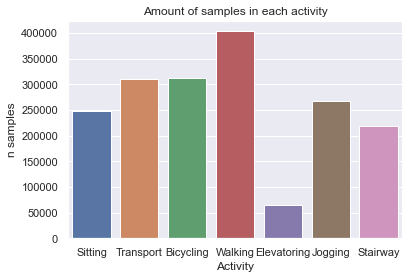

In [4]:
# set sns plot size to (21, 10)
sns.set(rc={'figure.figsize': (21, 10)})
# plot amount of samples in df.activity
sns.countplot(df.activity)
plt.xlabel("Activity")
plt.ylabel("n samples")
plt.title("Amount of samples in each activity")
plt.show()

Elevatoring is undersampled. The recognition of elevatoring is not mandatory in the challenge. Therefore not many samples were collected. 

## Splitting data
The data is split with StratifiedShuffleSplit to keep the proportions of the different classes intact.

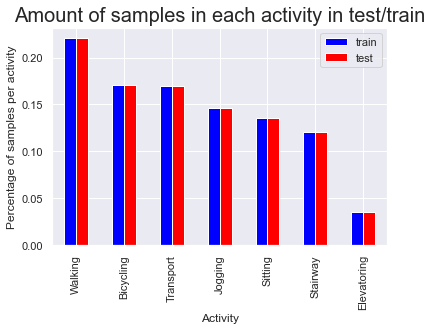

In [5]:
# split df into train and test StratifiedShuffleSplit by activity
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_index, test_index = next(split.split(df, df.activity))
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]

n_rows = train_df.shape[0]
train = (train_df.activity.value_counts() / n_rows)
n_rows = test_df.shape[0]
test =  (test_df.activity.value_counts() / n_rows)

plot_df = pd.DataFrame({"train": train, "test": test})
plot_df.plot.bar(color=["blue", "red"])
plt.legend()
plt.ylabel("Percentage of samples per activity")
plt.xlabel("Activity")
plt.title("Amount of samples in each activity in test/train", fontdict={"fontsize": 20})
plt.show()

## Encoding activity

In [6]:
df.activity.unique()

array(['Sitting', 'Transport', 'Bicycling', 'Walking', 'Elevatoring',
       'Jogging', 'Stairway'], dtype=object)

In [7]:
# encode activities to numbers
df.activity = df.activity.map({'Sitting': 0, 'Transport': 1, 'Bicycling':2, 'Walking':3, 'Elevatoring':4, 'Jogging':5, 'Stairway':6})

In [8]:
df.activity.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [9]:
# splitting df again into train and test
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_index, test_index = next(split.split(df, df.activity))
train_df = df.iloc[train_index]
test_df = df.iloc[test_index]

# Turning raw data into samples

To train a model that recognizes activity, the input data is a timeseries which contains datapoints over a period of time. With a single recorded datapoint the model won't be able to recognize the activity. 

Therefore the data was split into recording samples. With recording samples are all the datapoints meant which were created during a recording session. 

The recording are further split into model samples which can be served to a model. The model samples are smaples over a timespan of 2.56 seconds and can have around 50% overlap. This seems to be a standart procedure in activity recognition. (https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) (https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)

## Creating test dataset for testing splitting

In [10]:
test = df.iloc[:1000,:]

## Check for amount of different activities

In [11]:
# check how many recording samples are in test
print(test.activity.unique())
print(test.name.unique())

[0 1 2]
['Raphi' 'pascal']


## Create columns for distinguishing samples

In [12]:
def prep_df(df):
    # copy time to new column and move it one row down
    df['time_copy'] = df.time

    # move time_copy next to the front
    columns = list(df.columns)
    columns = columns[-1:] + columns[:-1]
    df = df[columns]

    # shift time copy
    df.time_copy = df.time_copy.shift(-1)

    # calc diff
    df['time_diff'] = (pd.to_datetime(df.time_copy) - pd.to_datetime(df.time))
    df['time_diff'] = df['time_diff'].abs()

    # apply total seconds
    df.time_diff = df.time_diff.apply(lambda x: x.total_seconds())

    # set sampleid to 0
    df['sampleid'] = 0

    # copy activity to new column and move it one row down
    df['activity_copy'] = df.activity
    df.activity_copy = df.activity_copy.shift(-1)

    # check if activity is the same
    df['activity_diff'] = df.activity == df.activity_copy

    return df

In [13]:
test = prep_df(test)

/var/folders/w3/qczdk1p16437g5rs9gnqc6_c0000gn/T/ipykernel_61824/2701864076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_copy'] = df.time


## Check where splitting should occur

In [14]:
test[test.activity_diff != True]

,time_copy,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,...,ori_x,ori_y,ori_z,ori_w,lat,long,time_diff,sampleid,activity_copy,activity_diff
200,2022-04-03 07:45:01.017,2022-04-03 11:47:22.835,Raphi,0,-0.121379,0.333922,0.940268,-21.4354,-26.75460,-32.07380,...,0.141825,-0.114015,-0.850270,0.493864,47.500155,8.324881,14541.818,0,1.0,False
803,2022-03-03 17:15:40.471,2022-04-03 07:49:28.105,pascal,1,-0.089975,0.397401,0.926030,-1.5375,-16.53750,6.43125,...,0.184056,0.099057,0.249243,0.945597,47.469938,8.317365,2644427.634,0,2.0,False
999,NaN,2022-03-03 17:15:51.148,pascal,2,0.670832,-0.326787,-0.508627,-23.9250,29.76563,40.23750,...,-0.081741,-0.893293,-0.197210,0.395543,47.455777,8.324452,NaN,0,NaN,False


## set sampleid

In [15]:
def set_sampleid(df:pd.DataFrame):
    # create sampleids
    prev_index = -1
    id = 0

    # create indexes where activity is not the same and time diff is greater than 1
    indexes = df[(df.activity_diff == False) & (df.time_diff > 1)].index.tolist()

    for index in indexes:
        df.loc[prev_index+1:index, 'sampleid'] = id
        prev_index = index
        id += 1
    df.loc[prev_index+1:, 'sampleid'] = id

    return df

In [16]:
test = set_sampleid(test)
test

,time_copy,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,...,ori_x,ori_y,ori_z,ori_w,lat,long,time_diff,sampleid,activity_copy,activity_diff
0,2022-04-03 11:47:11.268,2022-04-03 11:47:11.212,Raphi,0,-0.091133,0.351148,0.945756,-23.01530,-26.72410,-33.40970,...,0.136017,-0.125171,-0.839552,0.510817,47.500155,8.324881,0.056,0,0.0,True
1,2022-04-03 11:47:11.326,2022-04-03 11:47:11.268,Raphi,0,-0.097963,0.366881,0.898528,-22.97260,-26.59600,-33.26940,...,0.135422,-0.126965,-0.839437,0.510728,47.500155,8.324881,0.058,0,0.0,True
2,2022-04-03 11:47:11.388,2022-04-03 11:47:11.326,Raphi,0,-0.114793,0.334654,0.998473,-22.77740,-26.51060,-33.09250,...,0.134209,-0.126197,-0.839677,0.510821,47.500155,8.324881,0.062,0,0.0,True
3,2022-04-03 11:47:11.445,2022-04-03 11:47:11.388,Raphi,0,-0.075767,0.364564,0.886332,-22.94210,-26.77900,-32.94610,...,0.134518,-0.133009,-0.839076,0.510125,47.500155,8.324881,0.057,0,0.0,True
4,2022-04-03 11:47:11.504,2022-04-03 11:47:11.445,Raphi,0,-0.125556,0.378345,0.905358,-23.32640,-27.35240,-32.97050,...,0.139961,-0.133803,-0.836808,0.512193,47.500155,8.324881,0.059,0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-03-03 17:15:50.985,2022-03-03 17:15:50.930,pascal,2,0.504633,-0.238825,-0.281297,-18.50625,34.36875,44.21250,...,-0.136460,-0.855389,-0.078397,0.493501,47.455777,8.324452,0.055,2,2.0,True
996,2022-03-03 17:15:51.040,2022-03-03 17:15:50.985,pascal,2,0.542593,-0.214281,-0.411243,-18.56250,30.31875,44.76563,...,-0.119247,-0.865423,-0.103203,0.475575,47.455777,8.324452,0.055,2,2.0,True
997,2022-03-03 17:15:51.094,2022-03-03 17:15:51.040,pascal,2,0.609090,-0.123391,-0.446993,-20.55000,27.30000,44.58750,...,-0.104388,-0.874805,-0.123782,0.456616,47.455777,8.324452,0.054,2,2.0,True
998,2022-03-03 17:15:51.148,2022-03-03 17:15:51.094,pascal,2,0.682662,-0.193060,-0.514710,-21.84375,27.78750,43.05000,...,-0.087123,-0.887810,-0.170553,0.418468,47.455777,8.324452,0.054,2,2.0,True


In [17]:
for i in [0,1,2]:
    assert test[test.sampleid == i].activity.unique()[0] == i

## Split a single sample into model samples

In [18]:
test_model = test[test.sampleid == 0].drop(columns=['time_copy', 'activity_copy', 'activity_diff'])
print(test_model.iloc[:43,:].sum().time_diff, test_model.iloc[:43,:].count().activity)
print(test_model.iloc[44:44+43,:].sum().time_diff, test_model.iloc[43:44+42,:].count().activity)

2.502 43
2.538 43


In [19]:
splits = np.array_split(test_model.iloc[:int(np.floor(test_model.shape[0] / 43)) * 43, :], 4)
[split.time_diff.sum() for split in splits]

[2.502, 2.5360000000000005, 2.4650000000000003, 2.4489999999999994]

43 samples seem to amount to a timerange around 2.56 seconds. 

## Function for creating np arrays with X and y data

In [20]:
def create_modelsampleids(df:pd.DataFrame, samplesize:int) -> np.array:
    X = []
    y = []

    df = df.drop(columns=['time_copy', 'time_diff', 'activity_copy', 'activity_diff', 'name', 'time'])


    for id in list(df.sampleid.unique()):
        # filter by id
        temp = df[df.sampleid == id]
        temp = temp.drop(columns=['sampleid'])

        # get y value
        temp_y = temp.activity.iloc[0]

        # drop activity
        temp = temp.drop(columns=['activity'])
        
        # determine amount of samples to take
        n = int(np.floor(temp.shape[0] / samplesize))
        temp = temp.iloc[:n*samplesize,:]

        # split samples
        splits = np.array_split(temp, n)

        # append splitted samples to X
        for split in splits:
            split = np.array(split)
            X.append(split)
            y.append(temp_y)

    data = (np.array(X), np.array(y))

    return data

In [21]:
test.columns

Index(['time_copy', 'time', 'name', 'activity', 'acc_x', 'acc_y', 'acc_z',
       'mag_x', 'mag_y', 'mag_z', 'gyr_x', 'gyr_y', 'gyr_z', 'ori_x', 'ori_y',
       'ori_z', 'ori_w', 'lat', 'long', 'time_diff', 'sampleid',
       'activity_copy', 'activity_diff'],
      dtype='object')

In [22]:
data = create_modelsampleids(test, 43)
data[1].shape, data[0].shape

((22,), (22, 43, 15))

## Function for creating df with model sample id

In [23]:
def create_modelsampleids_df(df:pd.DataFrame, samplesize:int) -> (pd.DataFrame, np.array):
    df['modelsampleid'] = 0
    columns = list(df.columns)
    count = 0
    df_ids = pd.DataFrame(columns=columns)
    print(df.activity.unique())

    for id in list(df.sampleid.unique()):
        # filter by id
        temp = df[df.sampleid == id]
        
        # determine amount of samples to take
        n = int(np.floor(temp.shape[0] / samplesize))
        temp = temp.iloc[:n*samplesize,:]

        # split samples
        splits = np.array_split(temp, n)

        for split in splits:
            split['modelsampleid'] = count
            count += 1

        temp = np.vstack(splits)
        # np array to df_ids
        temp = pd.DataFrame(temp, columns=columns)

        df_ids = pd.concat([df_ids, temp])

    df_ids = df_ids.reset_index()
    df_ids = df_ids.drop(columns=['index', 'time_copy', 'time_diff', 'activity_copy', 'activity_diff', 'sampleid', 'name'])
    assert df_ids.shape[0] / samplesize == df_ids['modelsampleid'].nunique()

    return df_ids

## Preparing arrays for model

In [24]:
df = pd.read_csv("../Analyse/df_clean.csv", index_col=0)
df.head()

,time,name,activity,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,gyr_x,gyr_y,gyr_z,ori_x,ori_y,ori_z,ori_w,lat,long
0,2022-04-03 11:47:11.212,Raphi,Sitting,-0.091133,0.351148,0.945756,-23.0153,-26.7241,-33.4097,0.047035,-0.022907,0.008399,0.136017,-0.125171,-0.839552,0.510817,47.500155,8.324881
1,2022-04-03 11:47:11.268,Raphi,Sitting,-0.097963,0.366881,0.898528,-22.9726,-26.5960,-33.2694,-0.050089,-0.041232,-0.025808,0.135422,-0.126965,-0.839437,0.510728,47.500155,8.324881
2,2022-04-03 11:47:11.326,Raphi,Sitting,-0.114793,0.334654,0.998473,-22.7774,-26.5106,-33.0925,0.150879,-0.098041,0.096972,0.134209,-0.126197,-0.839677,0.510821,47.500155,8.324881
3,2022-04-03 11:47:11.388,Raphi,Sitting,-0.075767,0.364564,0.886332,-22.9421,-26.7790,-32.9461,0.196082,0.096208,-0.009926,0.134518,-0.133009,-0.839076,0.510125,47.500155,8.324881
4,2022-04-03 11:47:11.445,Raphi,Sitting,-0.125556,0.378345,0.905358,-23.3264,-27.3524,-32.9705,0.027488,0.019242,0.138510,0.139961,-0.133803,-0.836808,0.512193,47.500155,8.324881


In [25]:
# encode activities to numbers
df.activity = df.activity.map({'Sitting': 0, 'Transport': 1, 'Bicycling':2, 'Walking':3, 'Elevatoring':4, 'Jogging':5, 'Stairway':6})

# prepare df
df = prep_df(df)

# set sample ids
df = set_sampleid(df)

# model sample ids
data = create_modelsampleids(df, 43)

In [26]:
# StratifiedShuffleSplit with data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(data[0], data[1]):
    X_train, X_test = data[0][train_index], data[0][test_index]
    y_train, y_test = data[1][train_index], data[1][test_index]

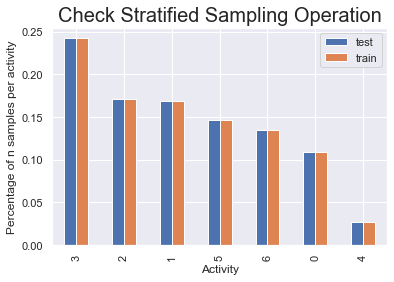

In [27]:
# Check stratified sampling operation
ntest = y_test.shape[0]
ntrain = y_train.shape[0]
pd.DataFrame({'test':pd.Series(y_test).value_counts() / ntest, 'train':pd.Series(y_train).value_counts() / ntrain}).plot.bar()
plt.title("Check Stratified Sampling Operation", fontsize=20)
plt.xlabel("Activity")
plt.ylabel("Percentage of n samples per activity")
plt.show()

In [28]:
# export data
np.savez('train.npz', X=X_train, y=y_train)
np.savez('test.npz', X=X_test, y=y_train)